# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [1]:
# student details 1: Nadav Izhaki 329087852
# student details 2: 
# student details 3: 

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 


AI agent name 2:
Goal:
Propmpt1:
    
Propmpt2:
    
Propmpt3: 

Other assistanse:    
</pre>

## Part 1(c) - Learning Problem and dataset explaination.

<pre>
Dataset Explanation:
    This dataset contains face images labeled as male or female. 
    It includes 1747 male and 1747 female images for training, and 100 male + 100 female images for both testing and validation. 
    The training and test are balanced, each containing roughly 50% male and 50% female images.
    All images were automatically cropped to show only the face using a tool called MTCNN.

I’m using this dataset to train a CNN (Convolutional Neural Network) model, 
which includes convolutional layers for feature extraction and fully connected layers at the end for decision making. 
The model will be used for binary classification to recognize whether a face image is male (1) or female (0).


Link to dataset: https://www.kaggle.com/datasets/gpiosenka/gender-classification-from-an-image

Note: You need to download the folder named gender_rev2 and then rename its folder to data.
</pre>

## Part 2 - Initial Preparations 

In [2]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm  

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as F

c:\Data\Projects\Repositories\Image_Gender_Classification-\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Check if torch is installed
print(f"Using torch version {torch.__version__}")

# Set device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} deivce") 

Using torch version 2.5.1+cu121
Using cuda deivce


In [4]:
# Start Hyperparameters
CLASS_NAMES = ["male", "female"]

RANDOM_SEED = 142  # Seed for reproducibility

BATCH_SIZE = 32
EPOCHS = 10
HIDDEN_UNITS = 64  # Number of filters in the convolutional layers
KERNEL_SIZE = 3  # Size of the convolutional filters (3x3)
STEP_SIZE = 1  # Stride of the convolutional filters (1 pixel step)
POOL_KERNEL_SIZE = 2  # Size of the max pooling window (2x2)

LERRNING_RATE = 0.001  # Learning rate for the optimizer

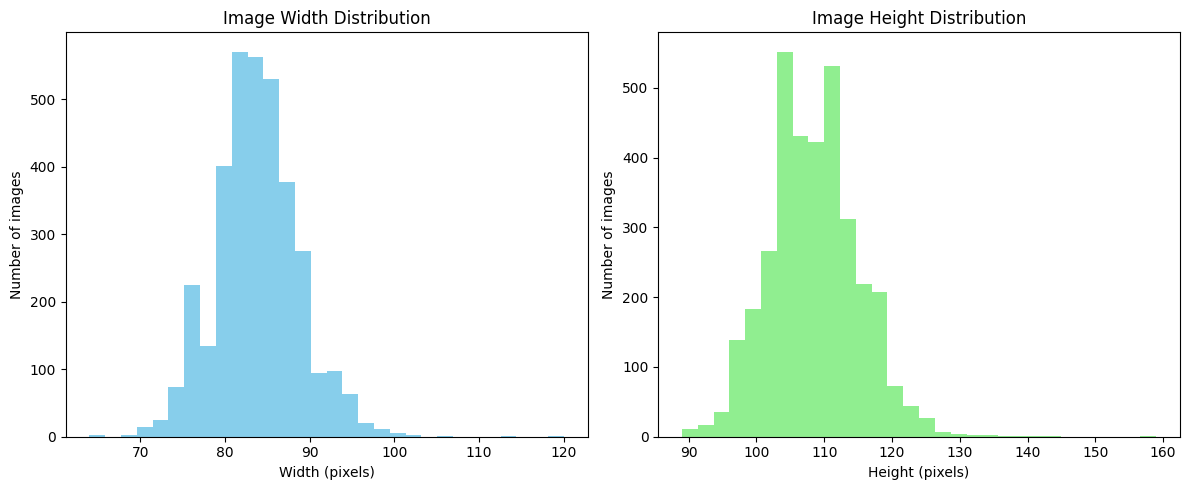

In [5]:
# Function to plot the distribution of image sizes in a directory

def plot_image_size_distribution(root_dir):
    widths = []
    heights = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.lower().endswith(('.jpg')):
                path = os.path.join(subdir, file)
                try:
                    img = Image.open(path)
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
                except Exception as e:
                    print(f"Error loading {path}: {e}")


    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=30, color='skyblue')
    plt.title('Image Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Number of images')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=30, color='lightgreen')
    plt.title('Image Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Number of images')

    plt.tight_layout()
    plt.show()


plot_image_size_distribution('data/train')

Based on the image size distribution, I chose 100×128 pixels. The function resizes each image to fit within this box without distortion, leaving smaller images unchanged, then pads them evenly with black borders to reach the exact size.

In [6]:
def pad_to_100x128(img):
    # Resize to fit inside 100x128, keep aspect ratio
    img.thumbnail((100, 128))  # modifies img in-place

    # Get new size
    w, h = img.size

    # Compute padding amounts (left, top, right, bottom)
    pad_left = (100 - w) // 2
    pad_top = (128 - h) // 2
    pad_right = 100 - w - pad_left
    pad_bottom = 128 - h - pad_top

    # Pad the image
    return F.pad(img, (pad_left, pad_top, pad_right, pad_bottom), fill=0)


transform = transforms.Compose([
    transforms.Lambda(pad_to_100x128),
    transforms.ToTensor()
])

In [7]:
# Load datasets
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset   = datasets.ImageFolder(root='data/valid', transform=transform)
test_dataset  = datasets.ImageFolder(root='data/test', transform=transform)

print(f"Label map of datset: {train_dataset.class_to_idx}")


Label map of datset: {'female': 0, 'male': 1}


In [8]:
# Create DataLoaders
torch.manual_seed(RANDOM_SEED)  # Set random seed for reproducibility
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nLength of Train dataloader: {len(train_loader)}, batches of {BATCH_SIZE}.")
print(f"Length of validation dataloader: {len(val_loader)}, batches of {BATCH_SIZE}.")
print(f"Length of Test dataloader: {len(test_loader)}, batches of {BATCH_SIZE}.")
print("The dataset is balanced with approximately 50% of images from each class (male and female).")



Length of Train dataloader: 110, batches of 32.
Length of validation dataloader: 7, batches of 32.
Length of Test dataloader: 7, batches of 32.
The dataset is balanced with approximately 50% of images from each class (male and female).


## Part 3 - Experiments
You could add as many code cells as needed

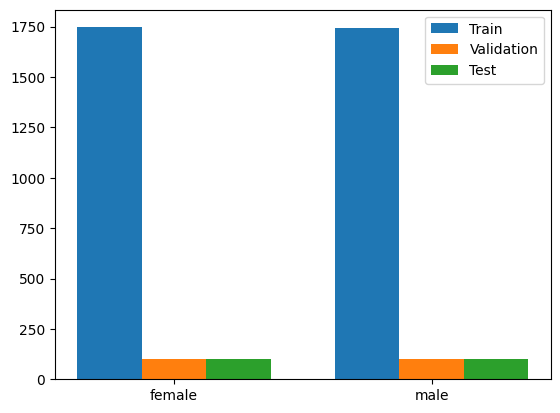

In [9]:
"""
Display the total number of samples from each dataset to get an overview of they sizes.
"""
from collections import Counter

# Count images per class in each dataset
train_counts = Counter([label for _, label in train_dataset])
val_counts = Counter([label for _, label in val_dataset])
test_counts = Counter([label for _, label in test_dataset])

classes = train_dataset.classes
x = range(len(classes))
width = 0.25  # width of each bar

# Plot bars for train, val, and test counts side by side
plt.bar([i - width for i in x], [train_counts[i] for i in x], width, label='Train')
plt.bar(x, [val_counts[i] for i in x], width, label='Validation')
plt.bar([i + width for i in x], [test_counts[i] for i in x], width, label='Test')

plt.xticks(x, classes)  # Label x-axis with class names
plt.legend()
plt.show()


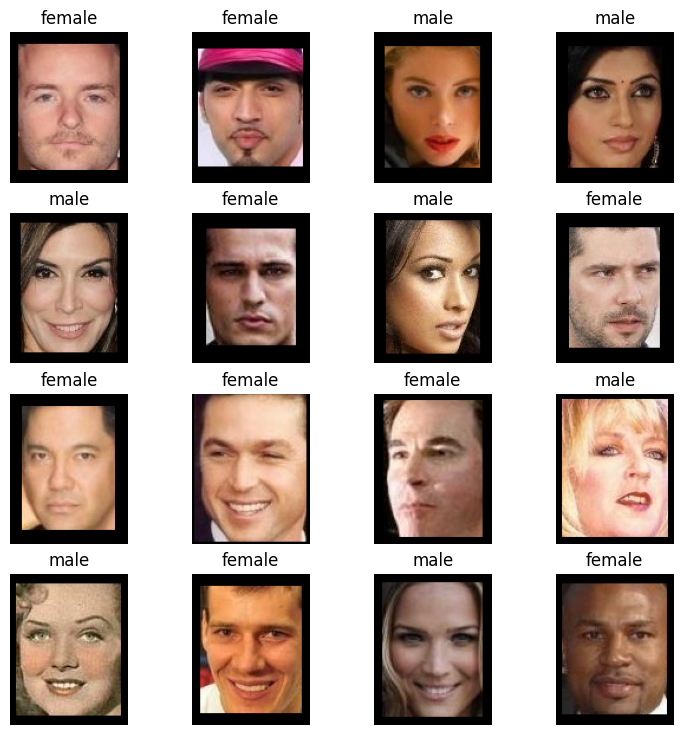

In [10]:
"""
Visualize example images from the dataset along with their labels to get a clear idea of what 
the data looks like and confirm the labels match the images.
"""
def plot_images_examples(datset, class_names):
    torch.manual_seed(RANDOM_SEED)
    fig = plt.figure(figsize=(9,9))
    rows, cols = 4, 4

    for i in range(1, rows*cols + 1):
        random_idx = torch.randint(0, len(datset), size=[1]).item()
        img, label = datset[random_idx]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        plt.title(class_names[label])
        plt.axis(False)

    plt.show()


plot_images_examples(datset=train_dataset, class_names=CLASS_NAMES)

## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [11]:
"""
Simple CNN model with 3 convolutional layers for feature extraction 
and 2 fully connected layer for binary classification (e.g., male vs female).
"""
class GenderClassifier(nn.Module):
    def __init__(self, hidden_units: int, kernel_size: int, step_size: int, pool_kernel_size: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3,  # Number of input channels, 3 for RGB images.
                      out_channels=hidden_units,  # Number of filters (feature maps) the layer will produce. ("num neurons")
                      kernel_size=kernel_size,  # Size of each filter (e.g., 3 means 3×3 kernels).
                      stride=step_size,  # How many pixels the filter moves at each step (1 = move one pixel at a time)
                      padding=0   # No padding here since images were already padded during dataset preparation to fit 100×128.
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)  # Window size, Take only the max vaue from each window step    
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, 
                      kernel_size=kernel_size, 
                      stride=step_size,  
                      padding=3  
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)    
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units, 
                      kernel_size=kernel_size, 
                      stride=step_size,  
                      padding=3  
            ),  
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=pool_kernel_size)    
        )

        self.fully_connected_1 = nn.Sequential(
            nn.Flatten(),  # Flatten the output from the convolutional layers to feed into the fully connected layer
            nn.Linear(in_features=15*18*hidden_units,  # Number of input features, calculated 2 boxes in ahead
                      out_features=hidden_units // 2),  
            nn.ReLU()  
        )

        self.fully_connected_2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units // 2, 
                      out_features=1  # Binary classification
            )
        )


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the model."""
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.fully_connected_1(x)
        x = self.fully_connected_2(x)
        return x
    

    def test_conv_layers(self, x: torch.Tensor) -> torch.Tensor:
        """Test the convolutional layers only."""
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        return x

In [12]:
# Create model instance
model = GenderClassifier(hidden_units=HIDDEN_UNITS,
                        kernel_size=KERNEL_SIZE,
                        step_size=STEP_SIZE,
                        pool_kernel_size=POOL_KERNEL_SIZE).to(device)

In [13]:
sample_input = torch.randn(1, 3, 100, 128).to(device)  # Random input tensor with shape (batch_size, channels, height, width)
output = model.test_conv_layers(sample_input)  
print(f"Sample logits shape: {output.shape}")  
"""
Output shape: torch.Size([1, batch_size, 15, 18]) wich means each image is reduced
to 15x18 feature maps after the convolutional layers.
from this we know the size of the input to the first fully connected layer is 15*18*hidden_units
"""

Sample logits shape: torch.Size([1, 64, 15, 18])


'\nOutput shape: torch.Size([1, batch_size, 15, 18]) wich means each image is reduced\nto 15x18 feature maps after the convolutional layers.\nfrom this we know the size of the input to the first fully connected layer is 15*18*hidden_units\n'

In [ ]:
# Binary Cross Entropy with Logits Loss For binary classification
loss_fn = nn.BCEWithLogitsLoss()

# Function to calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true,  y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

# Adam optimizer for training the model
optimizer = torch.optim.Adam(params=model.parameters(), lr=LERRNING_RATE)

In [ ]:
# Training loop
def train():
    model.train()
    total_loss, total_acc = 0, 0

    for batch, labels in tqdm(enumerate(train_loader)):
        print(batch.shape, labels.shape)  # Debugging: Check batch and labels shapes
        # Move data to device
        labels = labels.to(device)
        batch = batch.to(device)

        # Forward pass
        logits = model(batch)
        print(f"Logits shape: {logits.shape}")  # Should be [batch_size, 1] for binary classification
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        y_pred = torch.round(torch.sigmoid(logits))
        total_acc += accuracy_fn(y_true=labels, y_pred=y_pred)

    return total_loss / len(train_loader), total_acc / len(train_loader)


def evaluate():
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.no_grad():
        for batch, labels in tqdm(enumerate(val_loader)):
            # Move data to device
            labels = labels.to(device)
            batch = batch.to(device)

            # Forward pass
            logits = model(batch)
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # Calculate accuracy
            y_pred = torch.round(torch.sigmoid(logits))
            total_acc += accuracy_fn(y_true=labels, y_pred=y_pred)

    return total_loss / len(val_loader), total_acc / len(val_loader)


train_loss, train_acc = train()
print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.2f}%")

In [ ]:
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch}")

    print("training...")
    train_loss, train_acc = train()

    print("evaluating...")
    val_loss, val_acc = evaluate()

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

## Part 5 - Apply on test and show model performance estimation